# Importing essential libraries

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")

# Data exploration and vizualization

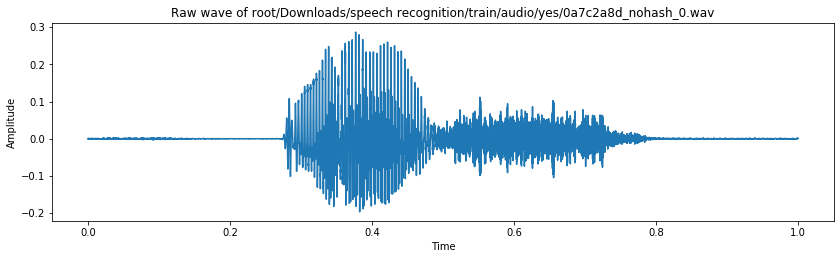

In [2]:
# Vizualization of audio signal in time domain
train_audio_path = '/root/Downloads/speech recognition/train/audio'
samples, sample_rate = librosa.load('/root/Downloads/speech recognition/train/audio/yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14,8))
ax1  = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'root/Downloads/speech recognition/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)


# Sampling Rate


In [3]:
ipd.Audio(samples, rate = sample_rate)
print(sample_rate)

16000


# Resampling


In [4]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate = 8000)

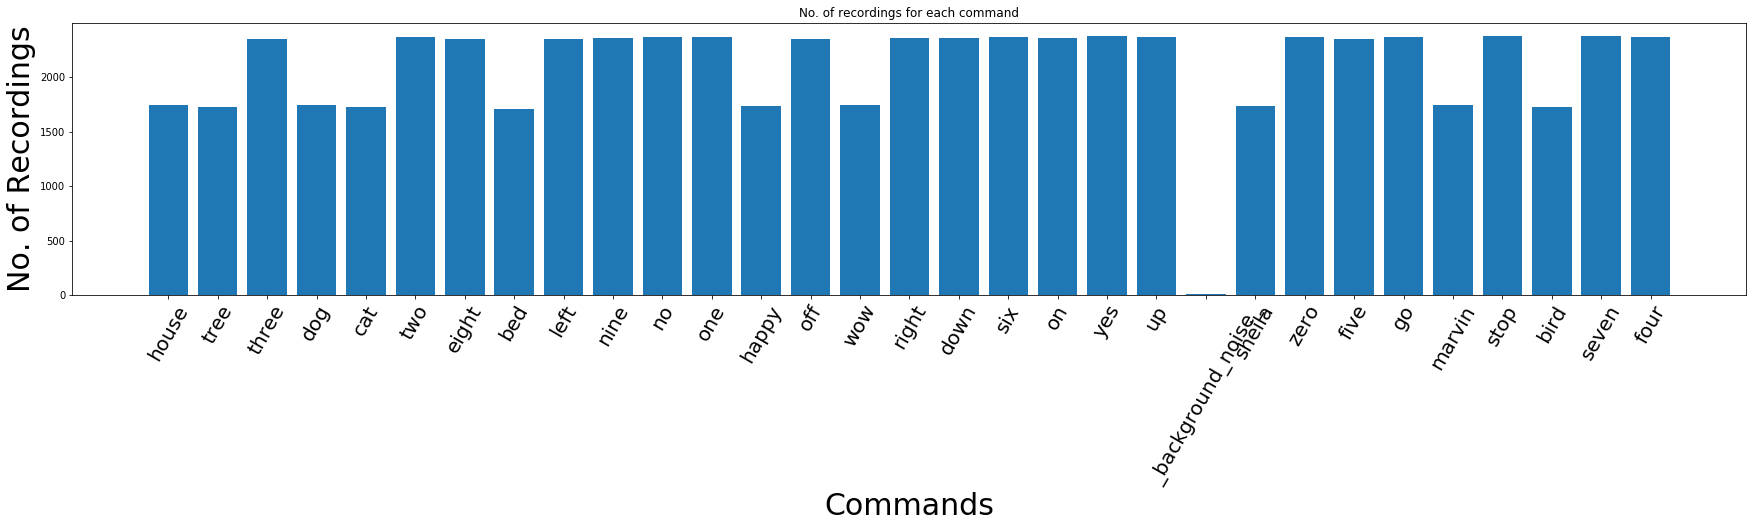

In [5]:
labels = os.listdir(train_audio_path)
no_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

plt.figure(figsize = (30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize = 30)
plt.ylabel('No. of Recordings', fontsize = 30)
plt.xticks(index, labels, fontsize = 20, rotation = 60)
plt.title('No. of recordings for each command')
plt.show()
#labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

# Duration of Recordings


(array([6.4721e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.3715625 ,  9.85271875, 19.333875  , 28.81503125, 38.2961875 ,
        47.77734375, 57.2585    , 66.73965625, 76.2208125 , 85.70196875,
        95.183125  ]),
 <a list of 10 Patch objects>)

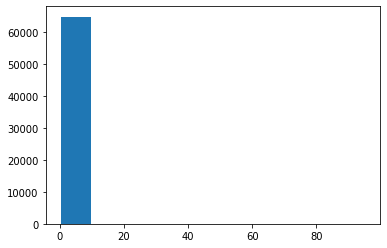

In [6]:
duration_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
plt.hist(np.array(duration_of_recordings))

# Preprocessing the audio waves

In [7]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr =16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples) == 8000):
            all_wave.append(samples)
            all_label.append(label)

house
tree
three
dog
cat
two
eight
bed
left
nine
no
one
happy
off
wow
right
down
six
on
yes
up
_background_noise_
sheila
zero
five
go
marvin
stop
bird
seven
four


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

In [9]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [10]:
all_wave = np.array(all_wave).reshape(-1, 8000, 1) #Reshape the 2D array to 3D since the input 
                                                   #to the conv1d must be a 3D array

# Splitting into training and testing datasets

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(all_wave), np.array(y), test_size = 0.20)

# Model Building

In [12]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as k
k.clear_session()
inputs = Input(shape = (8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation = 'relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation= 'relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation= 'softmax')(conv)

model = Model(inputs, outputs)
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
______________________________________________

In [13]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [15]:
history=model.fit(x_train, y_train, epochs=100, callbacks=[es,mc], batch_size=32, verbose = 1, validation_data=(x_test,y_test) )

Train on 46601 samples, validate on 11651 samples
Epoch 1/100
46592/46601 [============================>.] - ETA: 0s - loss: 2.7903 - acc: 0.1745
Epoch 00001: val_acc improved from -inf to 0.35902, saving model to best_model.hdf5
46601/46601 [==============================] - 319s 7ms/sample - loss: 2.7903 - acc: 0.1745 - val_loss: 2.0743 - val_acc: 0.3590
Epoch 2/100
46592/46601 [============================>.] - ETA: 0s - loss: 2.0430 - acc: 0.3588
Epoch 00002: val_acc improved from 0.35902 to 0.47472, saving model to best_model.hdf5
46601/46601 [==============================] - 311s 7ms/sample - loss: 2.0431 - acc: 0.3587 - val_loss: 1.6957 - val_acc: 0.4747
Epoch 3/100
46592/46601 [============================>.] - ETA: 0s - loss: 1.7829 - acc: 0.4402
Epoch 00003: val_acc improved from 0.47472 to 0.54631, saving model to best_model.hdf5
46601/46601 [==============================] - 303s 6ms/sample - loss: 1.7829 - acc: 0.4402 - val_loss: 1.4708 - val_acc: 0.5463
Epoch 4/100
46592

46592/46601 [============================>.] - ETA: 0s - loss: 0.7873 - acc: 0.7599
Epoch 00028: val_acc did not improve from 0.81057
46601/46601 [==============================] - 298s 6ms/sample - loss: 0.7874 - acc: 0.7599 - val_loss: 0.6575 - val_acc: 0.8053
Epoch 29/100
46592/46601 [============================>.] - ETA: 0s - loss: 0.7717 - acc: 0.7644
Epoch 00029: val_acc did not improve from 0.81057
46601/46601 [==============================] - 307s 7ms/sample - loss: 0.7716 - acc: 0.7645 - val_loss: 0.6598 - val_acc: 0.8029
Epoch 30/100
46592/46601 [============================>.] - ETA: 0s - loss: 0.7553 - acc: 0.7663
Epoch 00030: val_acc did not improve from 0.81057
46601/46601 [==============================] - 290s 6ms/sample - loss: 0.7552 - acc: 0.7663 - val_loss: 0.6576 - val_acc: 0.8023
Epoch 31/100
46592/46601 [============================>.] - ETA: 0s - loss: 0.7551 - acc: 0.7682
Epoch 00031: val_acc improved from 0.81057 to 0.81632, saving model to best_model.hdf5
4

# Diagnostic Plot

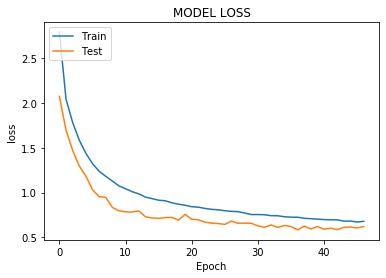

In [16]:
plt.plot(history.history['loss'], label = 'Train')
plt.plot(history.history['val_loss'], label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title("MODEL LOSS")
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

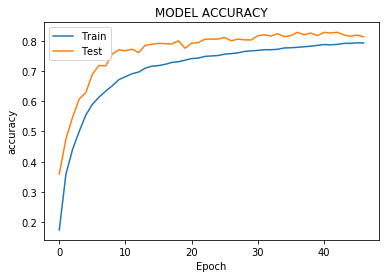

In [17]:
plt.plot(history.history['acc'], label = 'Train')
plt.plot(history.history['val_acc'], label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title("MODEL ACCURACY")
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

# Loading the best model

In [18]:
from tensorflow.keras.models import load_model
model = load_model('best_model.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
#Define the function that predicts text for the given audio
def predict(audio):
    prob = model.predict(audio.reshape(1,8000,1))
    index = np.argmax(prob[0])
    return classes[index]

In [20]:
import random
index = random.randint(0, len(x_test)-1)
samples = x_test[index].ravel()
print("Audio: ", classes[np.argmax(y_test[index])])
ipd.Audio(samples, rate = 8000)

Audio:  dog


In [21]:
print("Text: ", predict(samples))

Text:  dog
